![](../img/330-banner.png)

# Lecture 13: Feature engineering and feature selection 


Instructor: Amir Abdi

## Legends

    
| <img src="https://upload.wikimedia.org/wikipedia/commons/f/f8/This_is_the_photo_of_Arthur_Samuel.jpg" width="100"> | <img src="http://www.cs.cmu.edu/~tom/TomHead2-6-22-22.jpg" width="100">  | <img src="https://upload.wikimedia.org/wikipedia/commons/4/49/John_McCarthy_Stanford.jpg" width="100"> | <img src="https://datascience.columbia.edu/wp-content/uploads/2020/08/Vapnik_web.png" width="100"> | <img src="https://upload.wikimedia.org/wikipedia/commons/a/a1/Alan_Turing_Aged_16.jpg" width="100"> | <img src="https://upload.wikimedia.org/wikipedia/commons/1/1e/Yoshua_Bengio_2019_cropped.jpg" width="100"> |
| :-----------: | :-----------: | :-----------: | :-----------: | :-----------: | :-----------: | 
| Arthur Samuel       | Tom Mitchell       |John McCarthy|  Vladimir N. Vapnik | Alan Turing | Yoshua Bengio |
| (1901-1990)    | 1951 - Now       |  1927 – 2011 | 1936 - Now | 1912 – 1954 | 1964-Now |
| First computer learning program | 1997 ML Texbook, CMU Prof | Co-coined term AI, Lisp,<br> Time-sharing, Garbage collection | SVM | Turing Test, Turning Machine | Turing Award<br> Father of Deep Learning


| <img src="https://upload.wikimedia.org/wikipedia/commons/d/d2/Lloyd_Shapley_2_2012.jpg" width="100"> |
|   :-----------:  |
| Lloyd Shapley | 
| 1923-2016  |
| Shapley values (SHAP) |

## Recap of SHAP from previous session

### Force Plot (Local feature importance for a given sample)

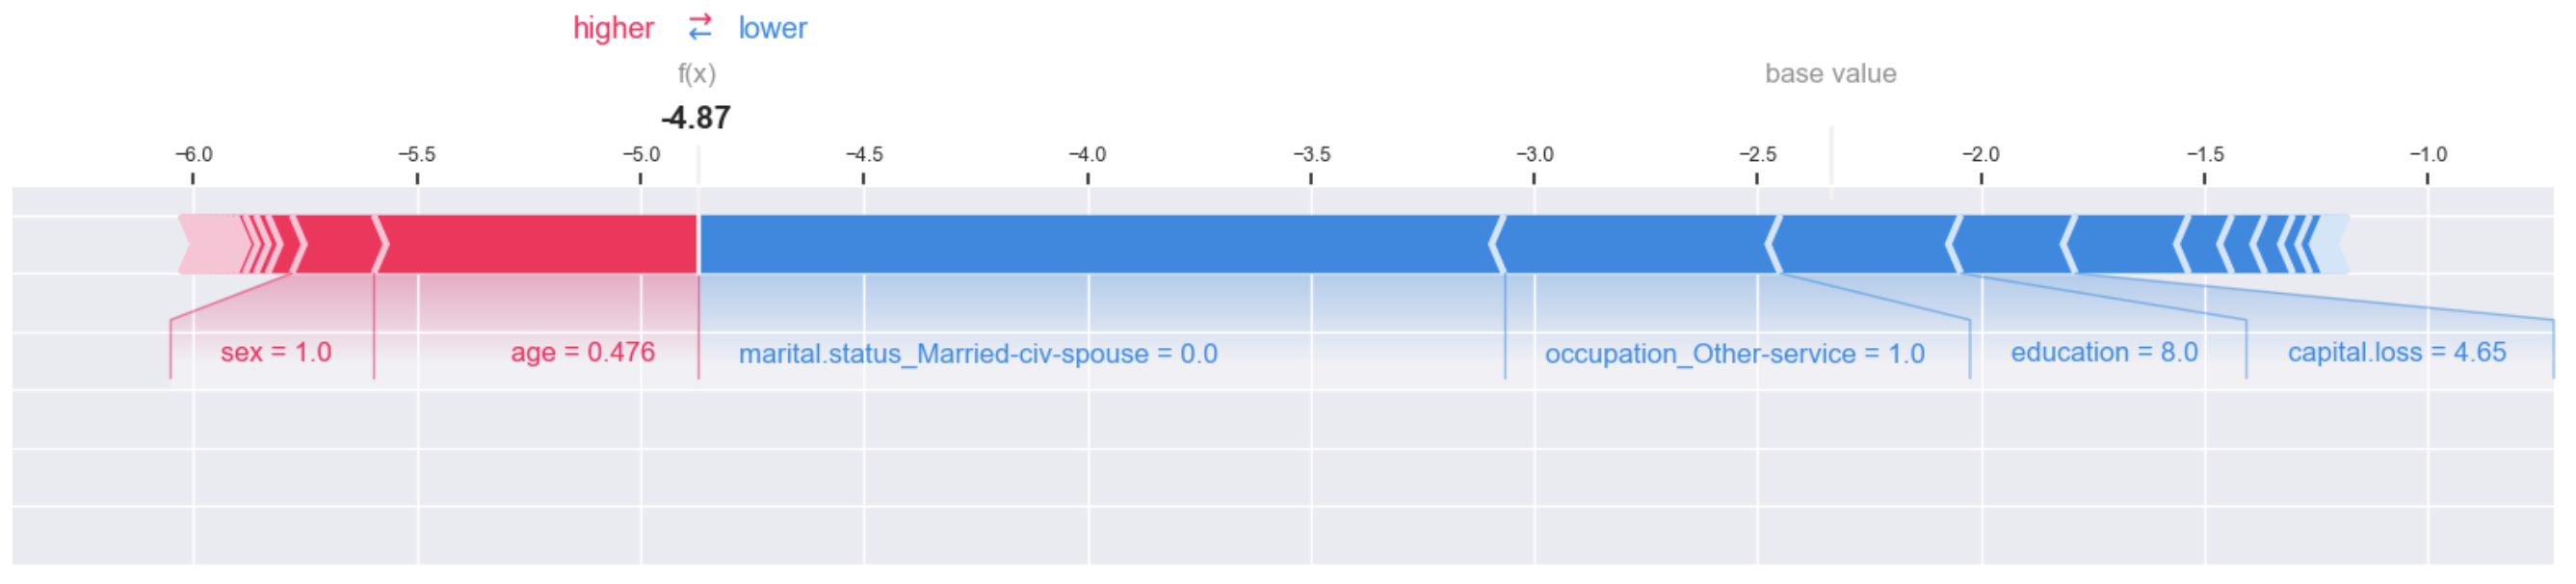

In the above, sum of all SHAP values for the given sample is: `-2.54`
This is the difference between 
- base value $E[f(x)]$   --> `(-2.34)`  
- $f(x)$  --> `(-4.87)`

### Dependency plot (Global feature importance of Age Feature in relation with Education)

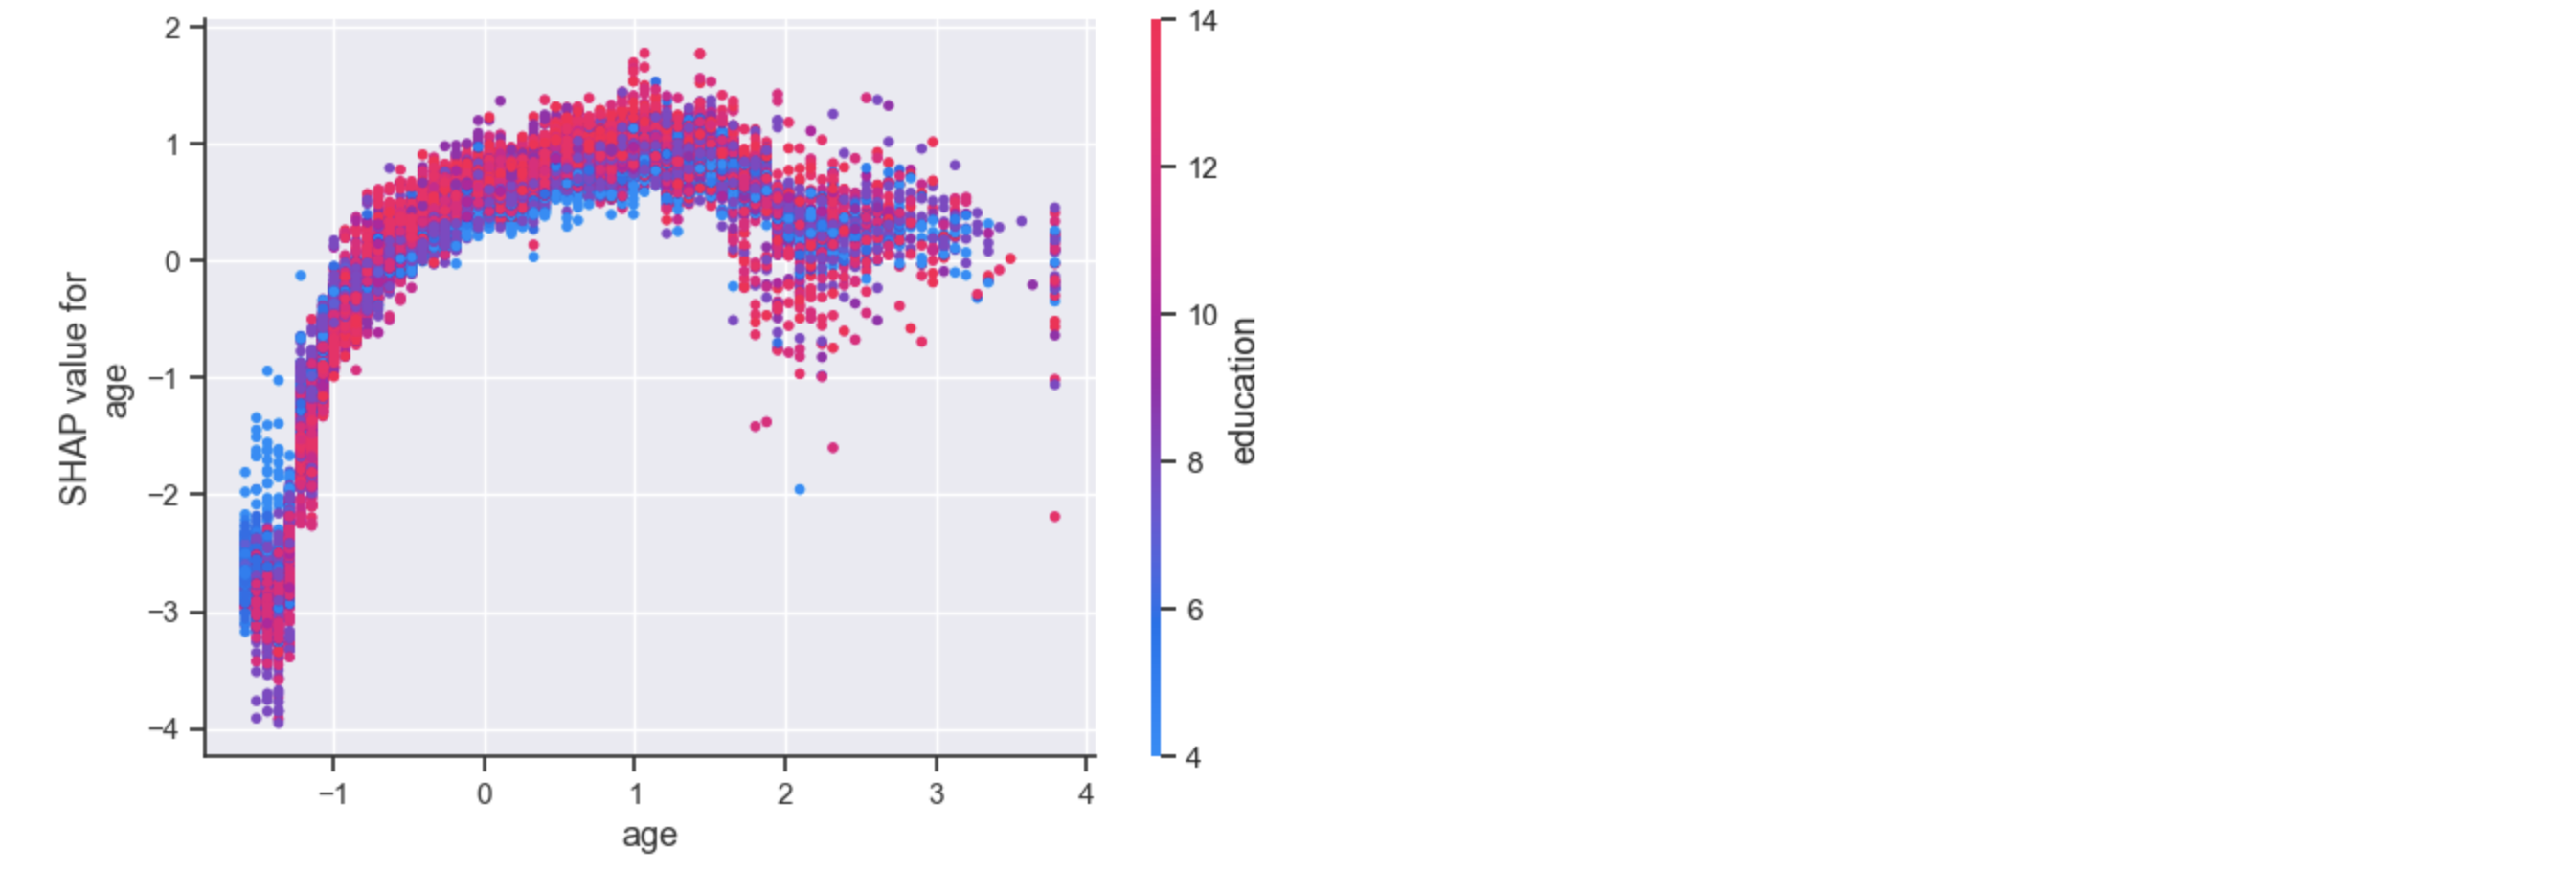

### Summary Plot (Global Feature importance of all features)

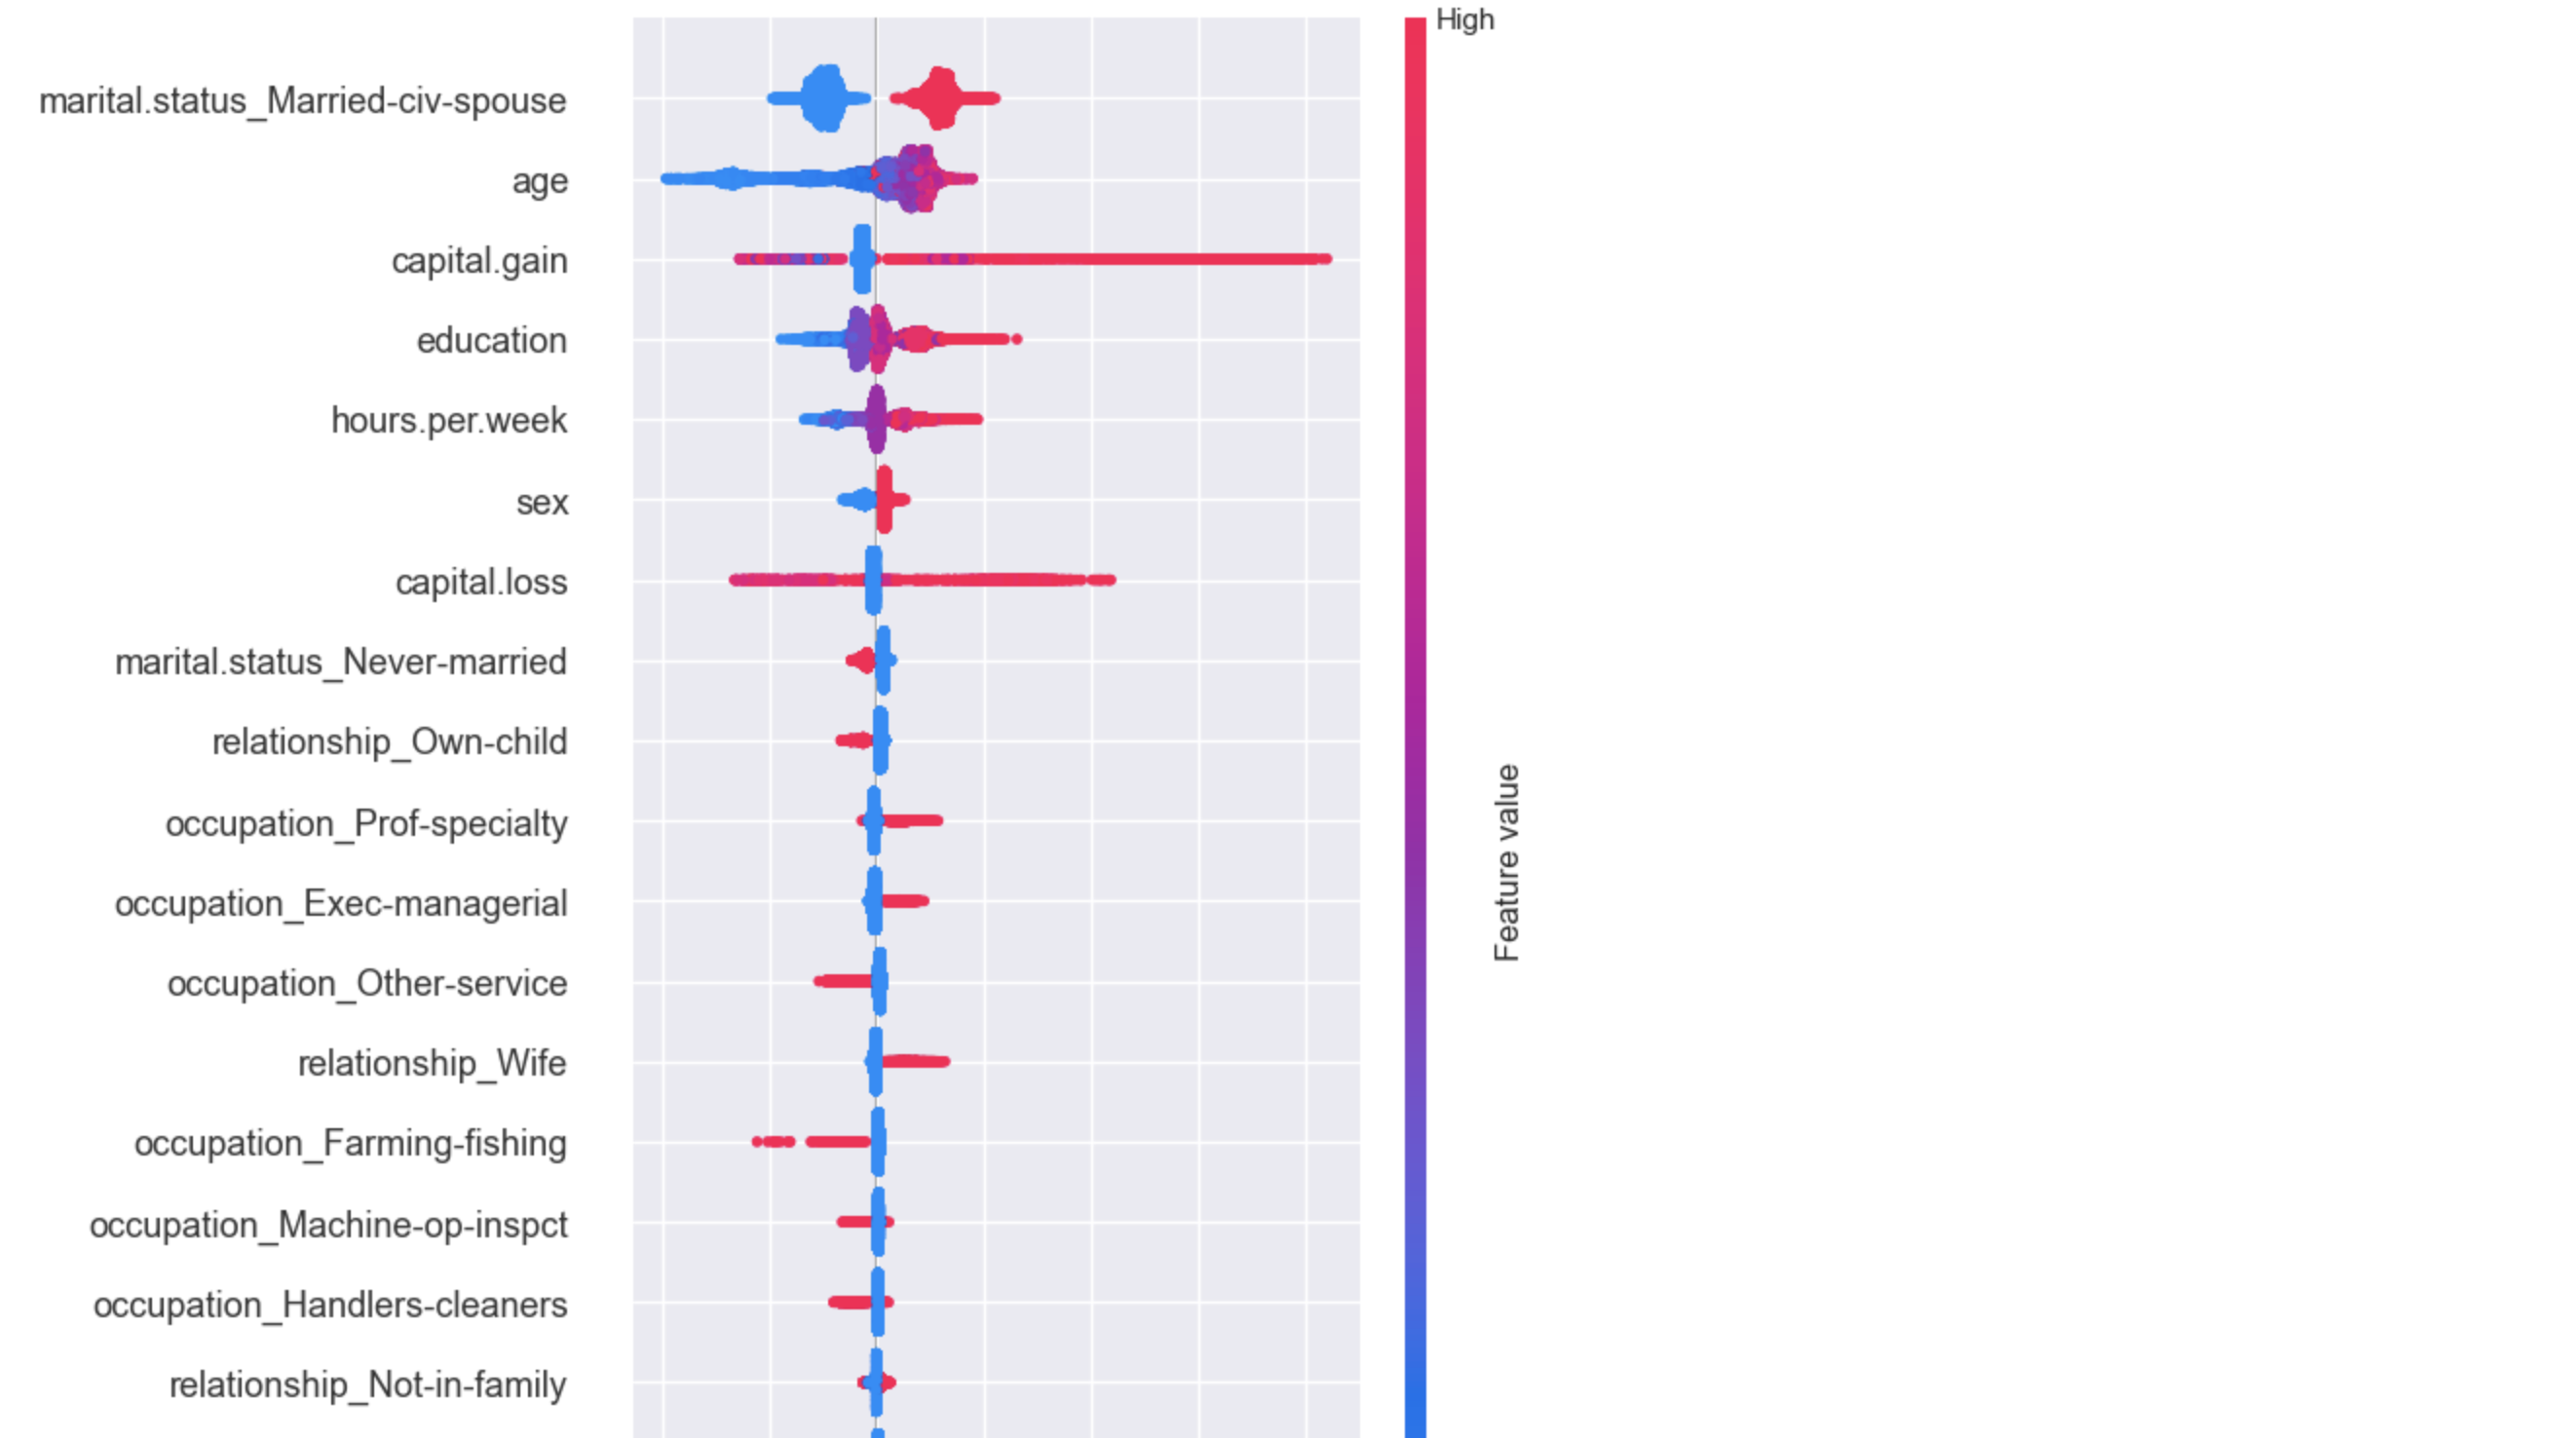

**Update:** I added more notes to the previous lecture notes under "**---- Update for clarity ----**". Check it out to resolve an ambiguity around `expected_values` of SHAP explainer.
<br><br><br><br><br>

## Imports

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
import pandas as pd
from sklearn.compose import (
    ColumnTransformer,
    TransformedTargetRegressor,
    make_column_transformer,
)
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, RidgeCV
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC

## Learning outcomes 

From this lecture, students are expected to be able to:

- Explain what feature engineering is and the importance of **feature engineering** in building machine learning models.  
- Carry out preliminary feature engineering on text data. 
- Explain the general concept of **feature selection**. 
- Discuss and compare different feature selection methods at a high level. 
- Use `sklearn`'s implementation of **recursive feature elimination** (`RFE`) and **forward and backward selection** (`SequentialFeatureSelector`). 

## Feature engineering: Motivation

### What is feature engineering?  

- Better features: more flexibility, higher score, we can get by with simple and more interpretable models. 
- If your features, i.e., representation is bad, whatever fancier model you build is not going to help.


> <b>Feature engineering</b> is the process of **transforming raw data into features** that **better represent** the underlying problem to the predictive models, resulting in improved model accuracy on unseen data.<br> 
\- Jason Brownlee (founder of https://machinelearningmastery.com/)    
<img src="https://machinelearningmastery.com/wp-content/uploads/2013/11/jason_brownlee-757x1024.jpg" width=100>


### Some quotes on feature engineering 

A quote by Pedro Domingos [A Few Useful Things to Know About Machine Learning](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

<blockquote>
... At the end of the day, some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used. 
</blockquote>


A quote by Andrew Ng, [Machine Learning and AI via Brain simulations](https://ai.stanford.edu/~ang/slides/DeepLearning-Mar2013.pptx)

<blockquote>
Coming up with features is difficult, time-consuming, requires expert knowledge. "Applied machine learning" is basically feature engineering.
</blockquote>

### Better features usually help more than a better model.
- Good features would ideally:
    - capture most important aspects of the problem
    - allow learning with few examples 
    - generalize to new scenarios.

- There is a trade-off between simple and expressive features:
    - With simple features overfitting risk is low, but scores might be low.
    - With complicated features scores can be high, but so is overfitting risk.

### The best features may be dependent on the model you use.

- Examples:
    - For distance-based methods like KNN, we want different class labels to be "far".
        - Standardization 
    - For regression-based methods, like linear regression, 
      - we want targets to have a linear dependency on features.

#### Domain-specific transformations

In some domains there are natural transformations to do:
- Spectrograms (sound data)
- Wavelets (image data)
- Fourier Transform
- Convolutions 

![](../img/spectogram.png)

<!-- <img src="img/spectogram.png" width="800" height="800"> -->

[Source](https://en.wikipedia.org/wiki/Spectrogram)

In this lecture, I'll show you an example of feature engineering on text data. 

<br><br><br><br>

## Feature engineering for text data 

We will be using [Covid tweets](https://www.kaggle.com/code/kerneler/starter-covid-19-nlp-text-d3a3baa6-e/data) dataset for this. 

In [2]:
df = pd.read_csv('../data/Corona_NLP_test.csv')
df['Sentiment'].value_counts()

Negative              1041
Positive               947
Neutral                619
Extremely Positive     599
Extremely Negative     592
Name: Sentiment, dtype: int64

In [3]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=123)

In [4]:
train_df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
1927,1928,46880,"Seattle, WA",13-03-2020,"While I don't like all of Amazon's choices, to...",Positive
1068,1069,46021,NaN,13-03-2020,"Me: shit buckets, its time to do the weekly s...",Negative
803,804,45756,The Outer Limits,12-03-2020,@SecPompeo @realDonaldTrump You mean the plan ...,Neutral
2846,2847,47799,"Flagstaff, AZ",15-03-2020,@lauvagrande People who are sick arent panic ...,Extremely Negative
3768,3769,48721,"Montreal, Canada",16-03-2020,Coronavirus Panic: Toilet Paper Is the People...,Negative
...,...,...,...,...,...,...
1122,1123,46075,NaN,13-03-2020,Photos of our local grocery store shelveswher...,Extremely Positive
1346,1347,46299,Toronto,13-03-2020,Just went to the the grocery store (Highland F...,Positive
3454,3455,48407,"Houston, TX",16-03-2020,Real talk though. Am I the only one spending h...,Neutral
3437,3438,48390,"Washington, DC",16-03-2020,The supermarket business is booming! #COVID2019,Neutral


In [5]:
train_df.columns

Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')

In [6]:
train_df['Location'].value_counts()

United States                     63
London, England                   37
Los Angeles, CA                   30
New York, NY                      29
Washington, DC                    29
                                  ..
Suburb of Chicago                  1
philippines                        1
Dont ask for freedom, take it.     1
Windsor Heights, IA                1
St James' Park, Newcastle          1
Name: Location, Length: 1441, dtype: int64

In [7]:
X_train, y_train = train_df[['OriginalTweet', 'Location']], train_df['Sentiment']
X_test, y_test = test_df[['OriginalTweet', 'Location']], test_df['Sentiment']

In [8]:
y_train.value_counts()

Negative              852
Positive              743
Neutral               501
Extremely Negative    472
Extremely Positive    470
Name: Sentiment, dtype: int64

In [9]:
scoring_metrics = 'accuracy'

In [10]:
results = {}

In [11]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

### Bag-of-words model 

We learned about `CountVectorizer` before that counts the number of occurances of words in the document:

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
pipe = make_pipeline(CountVectorizer(stop_words='english'), 
                     LogisticRegression(max_iter=1000))
results["logistic regression"] = mean_std_cross_val_scores(
    pipe, X_train['OriginalTweet'], y_train, return_train_score=True, scoring=scoring_metrics
)
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
logistic regression,0.781 (+/- 0.044),0.018 (+/- 0.001),0.413 (+/- 0.011),0.999 (+/- 0.000)


### Is it possible to further improve the scores?

Let's extract our own features that might be useful for this prediction task. In other words, let's carry out **feature engineering**. 

- The code below adds some very basic **length-related** and **sentiment** features. We will be using a popular library called `nltk` for this exercise. If you have successfully created the course `conda` environment on your machine, you should already have this package in the environment.  

<br><br><br><br><br>
Can we use  **pre-trained models** to extract information from text?

- A couple of popular libraries which include such pre-trained models. 
- `nltk`
```
conda install -c anaconda nltk 
```        
- spaCy
```
conda install -c conda-forge spacy
```

For emoji support: 
```
pip install spacymoji
```

- You also need to download the language model which contains all the pre-trained models. For that run the following in your course `conda` environment or here.  

In [ ]:
# !conda install -c anaconda nltk -y
# !conda install -c conda-forge spacy -y
# !pip install spacymoji

In [ ]:
# !python -m spacy download en_core_web_md

In [13]:
import spacy

Donwload and install dictionries and pre-built models:

In [14]:
import nltk
nltk.download("punkt")

[nltk_data] Downloading package punkt to /Users/amirabdi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

We can use an off-the-shelf sentiment analyzer such as **Vader**:
https://github.com/cjhutto/vaderSentiment

In [16]:
nltk.download("vader_lexicon")
nltk.download("punkt")

from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/amirabdi/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /Users/amirabdi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [17]:
s = "CPSC 330 students are smart, sweet, and funny."
print(sia.polarity_scores(s))

{'neg': 0.0, 'neu': 0.368, 'pos': 0.632, 'compound': 0.8225}


In [18]:
s = "CPSC 330 students are tired because of all the hard work they have been doing."
print(sia.polarity_scores(s))

{'neg': 0.249, 'neu': 0.751, 'pos': 0.0, 'compound': -0.5106}


In [19]:
s = "CPSC 330 students are badly tired because of all the hard work they have been doing."
print(sia.polarity_scores(s))

{'neg': 0.363, 'neu': 0.637, 'pos': 0.0, 'compound': -0.7506}


### [spaCy](https://spacy.io/) 

A useful package for text processing and feature extraction
- Active development: https://github.com/explosion/spaCy
- Interactive lessons by Ines Montani: https://course.spacy.io/en/
- Good documentation, easy to use, and customizable. 

In [20]:
import en_core_web_md  # pre-trained model
import spacy

nlpipe = en_core_web_md.load()

In [21]:
sample_text = """Dolly Parton is a gift to us all. 
From writing all-time great songs like “Jolene” and “I Will Always Love You”, 
to great performances in films like 9 to 5, to helping fund a COVID-19 vaccine, 
she’s given us so much. Now, Netflix bring us Dolly Parton’s Christmas on the Square, 
an original musical that stars Christine Baranski as a Scrooge-like landowner 
who threatens to evict an entire town on Christmas Eve to make room for a new mall. 
Directed and choreographed by the legendary Debbie Allen and counting Jennifer Lewis 
and Parton herself amongst its cast, Christmas on the Square seems like the perfect movie
to save Christmas 2020. 😻 👍🏿"""

# [Adapted from here.](https://thepopbreak.com/2020/11/22/dolly-partons-christmas-on-the-square-review-not-quite-a-christmas-miracle/)

Spacy extracts all interesting information from text with this call.

In [22]:
doc = nlpipe(sample_text)

Let's look at part-of-speech tags. 

In [23]:
print([(token, token.pos_) for token in doc][:20])

[(Dolly, 'PROPN'), (Parton, 'PROPN'), (is, 'AUX'), (a, 'DET'), (gift, 'NOUN'), (to, 'ADP'), (us, 'PRON'), (all, 'PRON'), (., 'PUNCT'), (
, 'SPACE'), (From, 'ADP'), (writing, 'VERB'), (all, 'DET'), (-, 'PUNCT'), (time, 'NOUN'), (great, 'ADJ'), (songs, 'NOUN'), (like, 'ADP'), (“, 'PUNCT'), (Jolene, 'PROPN')]


- Often we want to know who did what to whom. 
- **Named entities** give you this information.  
- What are named entities in the text? 

In [24]:
print("Named entities:\n", [(ent.text, ent.label_) for ent in doc.ents])

Named entities:
 [('Dolly Parton', 'PERSON'), ('Jolene', 'PERSON'), ('9 to 5', 'DATE'), ('Netflix', 'ORG'), ('Dolly Parton', 'PERSON'), ('Christmas', 'DATE'), ('Square', 'FAC'), ('Christine Baranski', 'PERSON'), ('Christmas Eve', 'DATE'), ('Debbie Allen', 'PERSON'), ('Jennifer Lewis', 'PERSON'), ('Parton', 'PERSON'), ('Christmas', 'DATE'), ('Square', 'FAC'), ('Christmas 2020', 'DATE')]


Or ask Spacy to explain different entities:

In [25]:
from spacy import displacy

displacy.render(doc, style="ent")

In [26]:
print("ORG means: ", spacy.explain("ORG"))
print("PERSON means: ", spacy.explain("PERSON"))
print("DATE means: ", spacy.explain("DATE"))
print("FAC means: ", spacy.explain("FAC"))

ORG means:  Companies, agencies, institutions, etc.
PERSON means:  People, including fictional
DATE means:  Absolute or relative dates or periods
FAC means:  Buildings, airports, highways, bridges, etc.


###  An example from a project 

Goal: Extract and visualize inter-corporate relationships from disclosed annual 10-K reports of public companies. 

[Source for the text below.](https://www.bbc.com/news/business-39875417)

In [27]:
text = (
    "Heavy hitters, including Microsoft and Google, "
    "are competing for customers in cloud services with the likes of IBM and Salesforce."
)

In [28]:
doc = nlpipe(text)
displacy.render(doc, style="ent")
print("Named entities:\n", [(ent.text, ent.label_) for ent in doc.ents])

Named entities:
 [('Microsoft', 'ORG'), ('Google', 'ORG'), ('IBM', 'ORG'), ('Salesforce', 'PRODUCT')]


If you want emoji identification support install [`spacymoji`](https://pypi.org/project/spacymoji/) in the course environment. 

In [29]:
from spacymoji import Emoji

nlpipe.add_pipe("emoji", first=True);

Does the text have any emojis? If yes, extract the description. 

In [30]:
doc = nlpipe(sample_text)
doc._.emoji

[('😻', 138, 'smiling cat face with heart-eyes'),
 ('👍🏿', 139, 'thumbs up dark skin tone')]

<br><br><br><br>

## Simple feature engineering for our problem. 

In [31]:
import en_core_web_md
import spacy

nlp = en_core_web_md.load()
from spacymoji import Emoji

nlp.add_pipe("emoji", first=True)

def get_relative_length(text, TWITTER_ALLOWED_CHARS=280.0):
    """
    Returns the relative length of text.

    Parameters:
    ------
    text: (str)
    the input text

    Keyword arguments:
    ------
    TWITTER_ALLOWED_CHARS: (float)
    the denominator for finding relative length

    Returns:
    -------
    relative length of text: (float)

    """
    return len(text) / TWITTER_ALLOWED_CHARS


def get_length_in_words(text):
    """
    Returns the length of the text in words.

    Parameters:
    ------
    text: (str)
    the input text

    Returns:
    -------
    length of tokenized text: (int)

    """
    return len(nltk.word_tokenize(text))


def get_sentiment(text):
    """
    Returns the compound score representing the sentiment: -1 (most extreme negative) and +1 (most extreme positive)
    The compound score is a normalized score calculated by summing the valence scores of each word in the lexicon.

    Parameters:
    ------
    text: (str)
    the input text

    Returns:
    -------
    sentiment of the text: (str)
    """
    scores = sia.polarity_scores(text)
    return scores["compound"]

def get_avg_word_length(text):
    """
    Returns the average word length of the given text.

    Parameters:
    text -- (str)
    """
    words = text.split()
    return sum(len(word) for word in words) / len(words)


def has_emoji(text):
    doc = nlp(text)
    return 1 if doc._.has_emoji else 0

Create a dataset with the new features (it takes time to calculate the features defined above)

In [32]:
train_df = train_df.assign(n_words=train_df["OriginalTweet"].apply(get_length_in_words))
train_df = train_df.assign(vader_sentiment=train_df["OriginalTweet"].apply(get_sentiment))
train_df = train_df.assign(rel_char_len=train_df["OriginalTweet"].apply(get_relative_length))

test_df = test_df.assign(n_words=test_df["OriginalTweet"].apply(get_length_in_words))
test_df = test_df.assign(vader_sentiment=test_df["OriginalTweet"].apply(get_sentiment))
test_df = test_df.assign(rel_char_len=test_df["OriginalTweet"].apply(get_relative_length))

train_df = train_df.assign(
    average_word_length=train_df["OriginalTweet"].apply(get_avg_word_length)
)
test_df = test_df.assign(average_word_length=test_df["OriginalTweet"].apply(get_avg_word_length))

Add some other handcrafted features:

In [33]:
# whether all letters are uppercase or not (all_caps)
train_df = train_df.assign(
    all_caps=train_df["OriginalTweet"].apply(lambda x: 1 if x.isupper() else 0)
)
test_df = test_df.assign(
    all_caps=test_df["OriginalTweet"].apply(lambda x: 1 if x.isupper() else 0)
)

Emoji features:

In [34]:
train_df = train_df.assign(has_emoji=train_df["OriginalTweet"].apply(has_emoji))
test_df = test_df.assign(has_emoji=test_df["OriginalTweet"].apply(has_emoji))

In [35]:
train_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,n_words,vader_sentiment,rel_char_len,average_word_length,all_caps,has_emoji
1927,1928,46880,"Seattle, WA",13-03-2020,"While I don't like all of Amazon's choices, to...",Positive,31,-0.1053,0.589286,5.640000,0,0
1068,1069,46021,NaN,13-03-2020,"Me: shit buckets, its time to do the weekly s...",Negative,52,-0.2500,0.932143,4.636364,0,0
803,804,45756,The Outer Limits,12-03-2020,@SecPompeo @realDonaldTrump You mean the plan ...,Neutral,44,0.0000,0.910714,6.741935,0,0
2846,2847,47799,"Flagstaff, AZ",15-03-2020,@lauvagrande People who are sick arent panic ...,Extremely Negative,46,-0.8481,0.907143,5.023810,0,0
3768,3769,48721,"Montreal, Canada",16-03-2020,Coronavirus Panic: Toilet Paper Is the People...,Negative,21,-0.5106,0.500000,9.846154,0,0


In [36]:
train_df.shape

(3038, 12)

We are including the **Generic sentiment analysis** of Vader library as a feature for our **COVID Sentiment analysis**:

In [37]:
train_df["vader_sentiment"]

1927   -0.1053
1068   -0.2500
803     0.0000
2846   -0.8481
3768   -0.5106
         ...  
1122    0.0000
1346   -0.6652
3454    0.0000
3437    0.0000
3582    0.0516
Name: vader_sentiment, Length: 3038, dtype: float64

In [38]:
X_train = train_df.drop(columns=['Sentiment'])

In [39]:
numeric_features = ['vader_sentiment', 
                    'rel_char_len', 
                    'average_word_length']
passthrough_features = ['all_caps', 'has_emoji'] 
text_feature = 'OriginalTweet'
drop_features = ['UserName', 'ScreenName', 'Location', 'TweetAt']

In [40]:
preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),
    ("passthrough", passthrough_features), 
    (CountVectorizer(stop_words='english'), text_feature),
    ("drop", drop_features)
)

In [41]:
pipe = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))
results["logistic regression (more feats)"] = mean_std_cross_val_scores(
    pipe, X_train, y_train, return_train_score=True, scoring=scoring_metrics
)

In [42]:
pd.DataFrame(results)

,logistic regression,logistic regression (more feats)
fit_time,0.781 (+/- 0.044),0.709 (+/- 0.074)
score_time,0.018 (+/- 0.001),0.017 (+/- 0.001)
test_score,0.413 (+/- 0.011),0.689 (+/- 0.007)
train_score,0.999 (+/- 0.000),0.998 (+/- 0.001)


We get some improvements with our engineered features!

Now, train the model on the entire Train set:

In [43]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['vader_sentiment',
                                                   'rel_char_len',
                                                   'average_word_length']),
                                                 ('passthrough', 'passthrough',
                                                  ['all_caps', 'has_emoji']),
                                                 ('countvectorizer',
                                                  CountVectorizer(stop_words='english'),
                                                  'OriginalTweet'),
                                                 ('drop', 'drop',
                                                  ['UserName', 'ScreenName',
                                                   'Location', 'TweetAt'])])),
                ('logisticregression', LogisticRegression(max_iter=1000))])

----------
**[study on your own]**

Check coefficients of Linear Regression for each feature:

In [ ]:
cv_feats = pipe.named_steps['columntransformer'].named_transformers_['countvectorizer'].get_feature_names()

In [ ]:
feat_names = numeric_features + passthrough_features + cv_feats

In [ ]:
coefs = pipe.named_steps['logisticregression'].coef_[0]

In [ ]:
df = pd.DataFrame(
    data={
        "features": feat_names,
        "coefficients": coefs,
    }
)
df.sort_values('coefficients')


**[study on your own]**

----------

<br><br><br><br>

## Common features used in text classification

### Bag of words 

- So far for text data we have been using bag of word features. 
- They are good enough for many tasks. But ... 
- This encoding throws out a lot of things we know about language
  - It assumes that word **order** is not important.   
- So if you want to improve the scores further on text classification tasks you carry out **feature engineering**. 

Let's look at some examples from research papers.  

### Example: Label "Personalized" Important E-mails: 
- [The Learning Behind Gmail Priority Inbox](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/36955.pdf)
- Features: bag of words, trigrams, regular expressions, and so on.
- There might be some "globally" important messages:
    - "This is your mother, something terrible happened, give me a call ASAP."
- But your "important" message may be unimportant to others.
     - Similar for spam: "spam" for one user could be "not spam" for another.

- Social features (e.g., percentage of sender emails that is read by the recipient)
- Content features (e.g., recent terms the user has been using in emails)
- Thread features (e.g., whether the user has started the thread)
- ...

### [The Learning Behind Gmail Priority Inbox](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/36955.pdf), Google, 2010

<!-- ![](../img/gmail_priority_inbox.png) -->

<img src="../img/gmail_priority_inbox.png" width="1000" height="1000">

#### Feature engineering examples: [Automatically Identifying Good Conversations Online](http://www.courtneynapoles.com/res/icwsm17-automatically.pdf)

<!-- ![](../img/classifying_good_conversations_online.png) -->

<img src="../img/classifying_good_conversations_online.png" width="800" height="800">


### (Optional) Term weighing (TF-IDF: Term Frequency-Inverse Document Frequency) 

- A measure of relatedness between words and documents
- Intuition: Meaningful words may occur repeatedly in related documents, but functional words (e.g., _make_, _the_) may be distributed evenly over all documents


$$tf.idf(w_i,d_j) = (1+log(tf_{ij})) log\frac{D}{df_i}$$


where, 
- $tf_{ij}$ &rarr; number of occurrences of the term $w_i$ in document $d_j$
- $D$ &rarr; number of documents
- $df_i$ &rarr; number of documents in which $w_i$ occurs

Check `TfidfVectorizer` from `sklearn`. 

### N-grams 

- Incorporating more context 
- A contiguous sequence of _n_ items (characters, tokens) in text.
    <blockquote>
        CPSC330 students are hard-working .
    </blockquote>    

- 2-grams (bigrams): a contiguous sequence of two words
    * _CPSC330 students, students are, are hard-working, hard-working ._
- 3-grams (trigrams): a contiguous sequence of three words
    * _CPSC330 students are, students are hard-working, are hard-working ._

You can extract ngram features using `CountVectorizer` by passing `ngram_range`. 

In [44]:
from sklearn.feature_extraction.text import CountVectorizer

X = [
    "URGENT!! As a valued network customer you have been selected to receive a $900 prize reward!",
    "Lol you are always so convincing.",
    "URGENT!! Call right away!!",
]

# ---------- New Code -------------------
vec = CountVectorizer(ngram_range=(1, 3))
# ----------------------------------------
X_counts = vec.fit_transform(X)
bow_df = pd.DataFrame(X_counts.toarray(), columns=vec.get_feature_names(), index=X)

/Users/amirabdi/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [45]:
bow_df

,900,900 prize,900 prize reward,always,always so,always so convincing,are,are always,are always so,as,...,urgent call,urgent call right,valued,valued network,valued network customer,you,you are,you are always,you have,you have been
URGENT!! As a valued network customer you have been selected to receive a $900 prize reward!,1,1,1,0,0,0,0,0,0,1,...,0,0,1,1,1,1,0,0,1,1
Lol you are always so convincing.,0,0,0,1,1,1,1,1,1,0,...,0,0,0,0,0,1,1,1,0,0
URGENT!! Call right away!!,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0


In [46]:
from IPython.display import HTML

url = "https://books.google.com/ngrams/"
HTML("<iframe src=%s width=1000 height=800></iframe>" % url)

/Users/amirabdi/miniconda3/envs/cpsc330/lib/python3.10/site-packages/IPython/core/display.py:419: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


### Part-of-speech features

#### Part-of-speech (POS) in English

- Part-of-speech: A kind of syntactic category that tells you some of the grammatical properties of a word.
    * Noun &rarr; water, sun, cat  
    * Verb &rarr; run, eat, teach

    
<blockquote>
The ____ was running. 
</blockquote>    

- Only a noun fits here. 

### Part-of-speech (POS) tagging

- POS features use POS information for the words in text.  

<blockquote>
    CPSC330/<span style="color:green">PROPER_NOUN</span> students/<span style="color:green">NOUN</span> are/<span style="color:green">VERB</span> hard-working/<span style="color:green">ADJECTIVE</span>
</blockquote>    


### An example from a project 

- Data: a bunch of documents 
- Task: identify texts with *permissions* and identify who is giving permission to whom. 

<blockquote>
<b>You</b> may <b>disclose</b> Google confidential information when compelled to do so by law if <b>you</b> provide <b>us</b> reasonable prior notice, unless a court orders that <b>we</b> not receive notice.
</blockquote>

- A very simple solution
    * Look for pronouns and verbs. 
    * Add POS tags as features in your model. 
    * Maybe look up words similar to **disclose**.
    

### Penn Treebank part-of-speech tags (bonus)

![](../img/PTB_POS.png)

<!-- <img src="img/PTB_POS.png" width="900" height="900"/> -->

- You also need to download the language model which contains all the pre-trained models. For that run the following in your course `conda` environment. 

### Interim summary 

- Feature engineering is finding the useful representation of the data that can help us effectively solve our problem. 
- In the context of text data, if we want to go beyond bag-of-words and incorporate human knowledge in models, we carry out feature engineering. 
- Some common features include:
    - ngram features
    - part-of-speech features / POS tagging
    - named entity features (NER)
    - emoticons in text
    - ...
- Today, with deep learning, a lost has changed in NLP. However, we still do *similar* (not the same) preprocessing steps to prepare tokens for the model.
- Even with Deep Learning, feature engineering is still important.

<br><br>

### Feature engineering 

- The best features are application-dependent.
- It's hard to give general advice. But here are some guidelines. 
    - Ask the domain experts.
    - Go through academic papers in the discipline. 
    - Often have idea of right discretization/standardization/transformation.
    - If no domain expert, cross-validation will help.

<blockquote>
    The algorithms we used are very standard for Kagglers ... We spent most of our efforts in feature engineering... <br>
- Xavier Conort, on winning the Flight Quest challenge on Kaggle    
</blockquote>    

[Ref](https://understandingdata.com/posts/11-feature-engineering-tactics-for-an-ml-project/)

## Break (5 min)

![](../img/eva-coffee.png)

<br><br><br><br>

## Feature selection: Introduction and motivation 


- With so many ways to add new features, we can increase dimensionality of the data. 
- More features means more complex models, which means increasing the chance of overfitting. 


### What is feature selection?

- Find the features	(columns) $X$ that are important for predicting	$y$, and remove the features that aren't. 

- Given $X = \begin{bmatrix}x_1 & x_2 & \dots & x_n\\  \\  \\  \end{bmatrix}$ and $y = \begin{bmatrix}\\  \\  \\  \end{bmatrix}$, find the columns $1 \leq j \leq n$ in $X$ that are important for predicting $y$.


### Why feature selection? 

- Interpretability: Models are **more interpretable** with fewer features. If you get the same performance with 10 features instead of 500 features, why not use the model with smaller number of features?     
- Computation: Models fit/predict faster with fewer columns.
- Data collection: What type of new data should I collect? It may be cheaper to collect fewer columns.
- Fundamental tradeoff: Can I reduce overfitting by removing useless features?
- Occam's Razor principle: Always search for smallest possible set of elements

Feature selection can often result in better performing (less overfit), easier to understand, and faster model. 


### How do we carry out feature selection? 

- There are a number of ways. 
- You could use domain knowledge to discard features. 
- We are briefly going to look at two automatic feature selection methods from `sklearn`: 
    - **Model-based selection** 
    - **Recursive feature elimination**
    - **Forward/backward selection**
- Very related to looking at feature importances.

In [47]:
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0, test_size=0.5
)

In [48]:
X_train.shape

(284, 30)

In [49]:
pipe_lr_all_feats = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
pipe_lr_all_feats.fit(X_train, y_train)
pd.DataFrame(
    cross_validate(pipe_lr_all_feats, X_train, y_train, return_train_score=True)
).mean()

fit_time       0.005051
score_time     0.000441
test_score     0.968233
train_score    0.987681
dtype: float64

### Model-based selection

- Use a supervised machine learning model to judge the importance of each feature.
- Keep only the most important ones
- Supervised machine learning model used for feature selection can be different that the one used as the final estimator. 
- Use a model which has some way to calculate feature importances.

- To use model-based selection, we use `SelectFromModel` transformer.
- It selects features which have the feature importances greater than the provided threshold.
- Below I'm using `RandomForestClassifier` for feature selection with **threahold as the "median" of feature importances**. 
- Approximately how many features will be selected? 
  - answer: ~50% of features


In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

# --------- New Code ---------------
select_rf = SelectFromModel(
    RandomForestClassifier(n_estimators=100, random_state=42), 
    threshold="median"
)
select_rf

SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median')

We can put the feature selection transformer in a pipeline. 

User RandomForest to select features, but then, train a LogisticRegression on the new subset of selected features.

In [51]:
pipe_lr_model_based = make_pipeline(
    StandardScaler(), select_rf, LogisticRegression(max_iter=1000)
)

pd.DataFrame(
    cross_validate(pipe_lr_model_based, X_train, y_train, return_train_score=True)
).mean()

fit_time       0.127419
score_time     0.013297
test_score     0.950564
train_score    0.974480
dtype: float64

In [52]:
pipe_lr_model_based.fit(X_train, y_train)
pipe_lr_model_based.named_steps["selectfrommodel"].transform(X_train).shape

(284, 15)

Comparable results with only 15 features instead of 30 features. 

### Recursive feature elimination (RFE)

- Build a series of models
- At each iteration, **discard the least important feature** according to the model. 
- Computationally expensive
- Basic idea
    - fit model
    - find least important feature
    - remove
    - iterate.

### RFE algorithm 

1. Decide $k$, the number of features to select. 
2. Assign importances to features, e.g. by fitting a model and looking at `coef_` or `feature_importances_`.
3. Remove the least important feature.
4. Repeat steps 2-3 until only $k$ features are remaining.

Note that this is **NOT** the same as just removing all the less important features in one shot!

**Why?**  
Answer: Because of the interactions (correlations) between features. If two features are related, removing one only makes the other feature even more valuable.

In [53]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [54]:
from sklearn.feature_selection import RFE

# create ranking of features
rfe = RFE(LogisticRegression(), n_features_to_select=5)
rfe.fit(X_train_scaled, y_train)
rfe.ranking_

array([16, 12, 19, 13, 23, 20, 10,  1,  9, 22,  2, 25,  5,  7, 15,  4, 26,
       18, 21,  8,  1,  1,  1,  6, 14, 24,  3,  1, 17, 11])

In [55]:
print(rfe.support_)

[False False False False False False False  True False False False False
 False False False False False False False False  True  True  True False
 False False False  True False False]


In [56]:
print("selected features: ", cancer.feature_names[rfe.support_])

selected features:  ['mean concave points' 'worst radius' 'worst texture' 'worst perimeter'
 'worst concave points']


- How do we know what value to pass to `n_features_to_select`?

- Use `RFECV` which uses cross-validation to select number of features. 

In [57]:
from sklearn.feature_selection import RFECV

rfe_cv = RFECV(LogisticRegression(max_iter=2000), cv=10)
rfe_cv.fit(X_train_scaled, y_train)
print('Original number of features:', X_train_scaled.shape[1])
print('Number of selected features:', sum(rfe_cv.support_), '\n\n')
print(cancer.feature_names[rfe_cv.support_])

Original number of features: 30
Number of selected features: 17 


['mean texture' 'mean area' 'mean concavity' 'mean concave points'
 'mean symmetry' 'radius error' 'perimeter error' 'area error'
 'compactness error' 'fractal dimension error' 'worst radius'
 'worst texture' 'worst perimeter' 'worst area' 'worst concavity'
 'worst concave points' 'worst fractal dimension']


In [59]:
rfe_pipe = make_pipeline(
    StandardScaler(),
    RFECV(LogisticRegression(max_iter=2000), cv=10),
    LogisticRegression(max_iter=1000)
)

pd.DataFrame(cross_validate(rfe_pipe, X_train, y_train, return_train_score=True)).mean()

fit_time       1.015791
score_time     0.000439
test_score     0.971867
train_score    0.986796
dtype: float64

- Slow because there is cross validation within cross validation 
- With fewer features (17 vs 30), we are achieving even higher CV scores, so, it is a win-win.

<br><br>

### Search and score

- Define a **scoring function** $f(S)$ that measures the quality of the set of features $S$. 
- Now **search** for the set of features $S$ with the best score.

### General idea of search and score methods 

- Example: Suppose you have three features: $A, B, C$
    - Compute **score** for $S = \{\}$
    - Compute **score** for $S = \{A\}$
    - Compute **score** for $S= \{B\}$
    - Compute **score** for $S = \{C\}$
    - Compute **score** for $S = \{A,B\}$    
    - Compute **score** for $S = \{A,C\}$
    - Compute **score** for $S = \{B,C\}$
    - Compute **score** for $S = \{A,B,C\}$    
- Return $S$ with the best score.  
- How many distinct combinations we have to try out for **n** features?
  - Answer: 2^items

### Forward or backward selection 

- Also called wrapper methods
- Shrink or grow feature set by removing or adding one feature at a time 
- Makes the decision based on whether adding/removing the feature improves the CV score or not

![](../img/forward_selection.png)

<!-- <img src='../img/forward_selection.png' width="1000" height="1000" /> -->

In [60]:
from sklearn.feature_selection import SequentialFeatureSelector

pipe_forward = make_pipeline(
    StandardScaler(),
    SequentialFeatureSelector(
          LogisticRegression(max_iter=1000), 
          direction="forward", # other options: 'backward'
          n_features_to_select='auto', 
          tol=None
    ),
    RandomForestClassifier(n_estimators=100, random_state=42),
)
pd.DataFrame(
    cross_validate(pipe_forward, X_train, y_train, return_train_score=True)
).mean()

fit_time       4.819933
score_time     0.008273
test_score     0.933020
train_score    1.000000
dtype: float64

In [61]:
pipe_forward = make_pipeline(
    StandardScaler(),
    SequentialFeatureSelector(
        LogisticRegression(max_iter=1000), 
                           direction="backward",
                           n_features_to_select=15),
    RandomForestClassifier(n_estimators=100, random_state=42),
)
pd.DataFrame(
    cross_validate(pipe_forward, X_train, y_train, return_train_score=True)
).mean()

fit_time       5.929753
score_time     0.007408
test_score     0.950627
train_score    1.000000
dtype: float64

### Other ways to search 

- Stochastic local search
    - Inject randomness so that we can explore new parts of the search space
    - Simulated annealing
    - Genetic algorithms

### Warnings about feature selection 

- A feature's relevance is only defined in the context of other features.
    - Adding/removing features can make features relevant/irrelevant.
- If features can be predicted from other features, you cannot know which one to pick. 
- Relevance for features does not have a causal relationship. 
- Don't be overconfident. 
    - The methods we have seen probably do not discover the ground truth and how the world really works.
    - They simply tell you which features help in predicting $y_i$ for the data you have.

### (iClicker) Exercise 13.1 

**iClicker cloud join link: https://join.iclicker.com/EMMJ**

**Select all of the following statements which are TRUE.**

- (A) Simple association-based feature selection approaches do not take into account the interaction between features.
- (B) You can carry out feature selection using linear models by pruning the features which have very small weights (i.e., coefficients less than a threshold).
- (C) Forward search is guaranteed to find the best feature set.  
- (D) The order of features removed given by `rfe.ranking_` is the same as the order of original feature importances given by the model.  

Correct answers:
- A
- B yes and no: depending on the scale of the features... if a feature has a big scale, the coefficient would be small.


<br><br><br><br><br>
## (Optional) Problems with feature selection 

- The term 'relevance' is not clearly defined.
- What all things can go wrong with feature selection?
- Attribution: From CPSC 340. 

#### Example: Is "Relevance" clearly defined?

- Consider a supervised classification task of predicting whether someone has particular genetic variation (SNP)

<img src='../img/sex_mom_dad.png' width="600" height="600" />

- True model: You almost have the same value as your biological mom.

#### Is "Relevance" clearly defined?

- True model: You almost have the same value for SNP as your biological mom.
    - (SNP = biological mom) with very high probability 
    - (SNP != biological mom) with very low probability 
    

<img src='../img/SNP.png' width="400" height="400"/>


#### Is "Relevance" clearly defined?

- What if "mom" feature is repeated?
- Should we pick both? Should we pick one of them because it predicts the other? 
- Dependence, collinearity for linear models
    - If a feature can be predicted from the other, don't know which one to pick. 

<img src='../img/sex_mom_mom2_dad.png' width="600" height="600"/>


#### Is "Relevance" clearly defined?

- What if we add (maternal) "grandma" feature?
- Is it relevant? 
    - We can predict SNP accurately using this feature
- **Conditional independence**
    - But grandma is irrelevant given biological mom feature
    - Relevant features may become irrelevant given other features

<img src='../img/sex_mom_dad_grandma.png' width="600" height="600"/>


#### Is "Relevance" clearly defined?

- What if we do not know biological mom feature and we just have grandma feature
- It becomes relevant now. 
    - Without mom feature this is the best we can do. 
- General problem ("taco Tuesday" problem): On Tuesdays, you eat Taco, and IgE of your blood goes up. But, Tuesday is irrelevant here; the only contributing factor is Taco. If you know about Taco, you can get rid of Tuesday.
    - Features can become **relevant due to missing information** 


<img src='../img/sex_dad_grandma.png' width="600" height="600"/>


#### Is "Relevance" clearly defined?

- Are there any relevant features now?
- They may have some common maternal ancestor.   
- What if mom likes dad because they share SNP? 
- General problem: **Confounding Factors**
    - **Hidden features** can make irrelevant features relevant.

<img src='../img/sex_dad.png' width="600" height="600"/>


#### Is "Relevance" clearly defined?

- Now what if we have "sibling" feature? 
- The feature is relevant in predicting SNP but not the cause of SNP. 
- General problem: **non causality**
    - the relevant feature may not be causal 

<img src='../img/sex_dad_sibling.png' width="600" height="600"/>


#### Is "Relevance" clearly defined?

- What if you are given "baby" feature?
- Now the sex feature becomes relevant. 
    - "baby" feature is relevant when sex == F
    
- General problem (context specific relevance)
    - **adding a feature (here: baby) can make an irrelevant feature (here: sex) relevant**

<img src='../img/sex_dad_baby.png' width="600" height="600"/>


#### Warnings about feature selection 

- A feature is only relevant in the context of other features.
    - Adding/removing features can make features relevant/irrelevant.
- **Confounding** factors can make irrelevant features the most relevant.
- If features can be predicted from other other features, you cannot know which one to pick. 
- **Relevance** for features does not have a **causal** relationship. 
- Is feature selection completely hopeless?
    - It is messy but we still need to do it. So we try to do our best! 

#### General advice on finding relevant features

- Try forward selection. 
- Try other feature selection methods (e.g., `RFE`, simulated annealing, genetic algorithms)
- Talk to domain experts; they probably have an idea why certain features are relevant.
- Don't be overconfident. 
    - The methods we have seen probably do not discover the ground truth and how the world really works.
    - They simply tell you which features help in predicting $y_i$.

#### Relevant resources 
- [Genome-wide association study](https://en.wikipedia.org/wiki/Genome-wide_association_study)
- [sklearn feature selection](https://scikit-learn.org/stable/modules/feature_selection.html)
- [PyData: A Practical Guide to Dimensionality Reduction Techniques](https://www.youtube.com/watch?v=ioXKxulmwVQ)